In [1]:
# Dependencies and Setup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from contextlib import redirect_stdout
import shap
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
pd.set_option('display.max_columns', None)
speeddate_df = pd.read_csv('speeddating.csv')
speeddate_df.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,attractive,sincere,intelligence,funny,ambition,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,b'',1.0,b'female',21.0,27.0,6.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,b'[2-5]',b'[2-5]',b'Law',35.0,20.0,20.0,20.0,0.0,5.0,b'[21-100]',b'[16-20]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,8.0,6.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',15.0,20.0,20.0,15.0,15.0,15.0,b'[0-15]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,7.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',6.0,9.0,7.0,7.0,6.0,5.0,b'[6-8]',b'[9-10]',b'[6-8]',b'[6-8]',b'[6-8]',b'[0-5]',9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,b'[9-10]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[9-10]',b'[9-10]',b'[9-10]',b'[6-8]',b'[0-5]',0.14,b'[0-0.33]',3.0,2.0,4.0,b'[0-4]',b'[0-3]',b'[3-5]',7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'0',b'0'
1,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,b'[2-5]',b'[2-5]',b'Law',60.0,0.0,0.0,40.0,0.0,0.0,b'[21-100]',b'[0-15]',b'[0-15]',b'[21-100]',b'[0-15]',b'[0-15]',7.0,8.0,10.0,7.0,7.0,5.0,b'[6-8]',b'[6-8]',b'[9-10]',b'[6-8]',b'[6-8]',b'[0-5]',15.0,20.0,20.0,15.0,15.0,15.0,b'[0-15]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,7.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',7.0,8.0,7.0,8.0,5.0,6.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[0-5]',b'[6-8]',9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,b'[9-10]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[9-10]',b'[9-10]',b'[9-10]',b'[6-8]',b'[0-5]',0.54,b'[0.33-1]',3.0,2.0,4.0,b'[0-4]',b'[0-3]',b'[3-5]',7.0,5.0,b'[6-8]',b'[5-6]',1.0,b'1',b'0',b'0'
2,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',b'1',2.0,4.0,b'[2-5]',b'[2-5]',b'Law',19.0,18.0,19.0,18.0,14.0,12.0,b'[16-20]',b'[16-20]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',10.0,10.0,10.0,10.0,10.0,10.0,b'[9-10]',b'[9-10]',b'[9-10]',b'[9-10]',b'[9-10]',b'[9-10]',15.0,20.0,20.0,15.0,15.0,15.0,b'[0-15]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,7.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',

In [3]:
# Drop unnecessary columns
speeddate_df.drop(columns=['has_null', 'field', 'decision', 'decision_o'], inplace=True)

In [4]:
speeddate_df.nunique()

wave                  21
gender                 2
age                   24
age_o                 24
d_age                 35
                      ..
guess_prob_liked      19
d_like                 3
d_guess_prob_liked     3
met                    7
match                  2
Length: 119, dtype: int64

In [5]:
nan_cols = []

for col in speeddate_df.columns:
    print(speeddate_df[col].value_counts())
    if speeddate_df[col].hasnans:
        nan_cols.append(col)
nan_cols

wave
21.0    968
11.0    882
9.0     800
14.0    720
15.0    684
4.0     648
2.0     608
7.0     512
19.0    450
12.0    392
17.0    280
3.0     200
8.0     200
1.0     200
5.0     190
13.0    180
10.0    162
16.0     96
20.0     84
18.0     72
6.0      50
Name: count, dtype: int64
gender
b'male'      4194
b'female'    4184
Name: count, dtype: int64
age
27.0    1059
23.0     894
26.0     869
24.0     863
25.0     837
28.0     746
22.0     655
29.0     589
30.0     574
21.0     291
32.0     210
33.0     161
34.0     152
31.0     125
35.0      60
20.0      55
36.0      45
19.0      20
42.0      20
38.0      19
39.0      18
18.0      10
55.0       6
37.0       5
Name: count, dtype: int64
age_o
27.0    1059
23.0     894
26.0     869
24.0     863
25.0     837
28.0     746
22.0     651
29.0     589
30.0     574
21.0     289
32.0     210
33.0     161
34.0     152
31.0     125
35.0      60
20.0      54
36.0      45
42.0      20
19.0      19
38.0      19
39.0      18
18.0       9
55.0       6
3

['age',
 'age_o',
 'importance_same_race',
 'importance_same_religion',
 'pref_o_attractive',
 'pref_o_sincere',
 'pref_o_intelligence',
 'pref_o_funny',
 'pref_o_ambitious',
 'pref_o_shared_interests',
 'attractive_o',
 'sinsere_o',
 'intelligence_o',
 'funny_o',
 'ambitous_o',
 'shared_interests_o',
 'attractive_important',
 'sincere_important',
 'intellicence_important',
 'funny_important',
 'ambtition_important',
 'shared_interests_important',
 'attractive',
 'sincere',
 'intelligence',
 'funny',
 'ambition',
 'attractive_partner',
 'sincere_partner',
 'intelligence_partner',
 'funny_partner',
 'ambition_partner',
 'shared_interests_partner',
 'sports',
 'tvsports',
 'exercise',
 'dining',
 'museums',
 'art',
 'hiking',
 'gaming',
 'clubbing',
 'reading',
 'tv',
 'theater',
 'movies',
 'concerts',
 'music',
 'shopping',
 'yoga',
 'interests_correlate',
 'expected_happy_with_sd_people',
 'expected_num_interested_in_me',
 'expected_num_matches',
 'like',
 'guess_prob_liked',
 'met']

In [6]:
speeddate_df.dropna(inplace=True)
speeddate_df

,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,attractive,sincere,intelligence,funny,ambition,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,match
0,1.0,b'female',21.0,27.0,6.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,b'[2-5]',b'[2-5]',35.0,20.0,20.0,20.0,0.0,5.0,b'[21-100]',b'[16-20]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,8.0,6.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',15.0,20.0,20.0,15.0,15.0,15.0,b'[0-15]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,7.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',6.0,9.0,7.0,7.0,6.0,5.0,b'[6-8]',b'[9-10]',b'[6-8]',b'[6-8]',b'[6-8]',b'[0-5]',9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,b'[9-10]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[9-10]',b'[9-10]',b'[9-10]',b'[6-8]',b'[0-5]',0.14,b'[0-0.33]',3.0,2.0,4.0,b'[0-4]',b'[0-3]',b'[3-5]',7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'0'
1,1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,b'[2-5]',b'[2-5]',60.0,0.0,0.0,40.0,0.0,0.0,b'[21-100]',b'[0-15]',b'[0-15]',b'[21-100]',b'[0-15]',b'[0-15]',7.0,8.0,10.0,7.0,7.0,5.0,b'[6-8]',b'[6-8]',b'[9-10]',b'[6-8]',b'[6-8]',b'[0-5]',15.0,20.0,20.0,15.0,15.0,15.0,b'[0-15]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,7.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',7.0,8.0,7.0,8.0,5.0,6.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[0-5]',b'[6-8]',9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,b'[9-10]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[9-10]',b'[9-10]',b'[9-10]',b'[6-8]',b'[0-5]',0.54,b'[0.33-1]',3.0,2.0,4.0,b'[0-4]',b'[0-3]',b'[3-5]',7.0,5.0,b'[6-8]',b'[5-6]',1.0,b'0'
3,1.0,b'female',21.0,23.0,2.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,b'[2-5]',b'[2-5]',30.0,5.0,15.0,40.0,5.0,5.0,b'[21-100]',b'[0-15]',b'[0-15]',b'[21-100]',b'[0-15]',b'[0-15]',7.0,8.0,9.0,8.0,9.0,8.0,b'[6-8]',b'[6-8]',b'[9-10]',b'[6-8]',b'[9-10]',b'[6-8]',15.0,20.0,20.0,15.0,15.0,15.0,b'[0-15]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,7.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',7.0,6.0,8.0,7.0,6.0,8.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',9.0,2.0,8.0,9.0,1.0,1.0,

In [7]:
for col in speeddate_df.columns[6:]:
    if 'd_' in col[0:2]:
        speeddate_df.drop(columns=col, inplace=True)

speeddate_df.head()

,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,match
0,1.0,b'female',21.0,27.0,6.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,35.0,20.0,20.0,20.0,0.0,5.0,6.0,8.0,8.0,8.0,8.0,6.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,6.0,9.0,7.0,7.0,6.0,5.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.14,3.0,2.0,4.0,7.0,6.0,0.0,b'0'
1,1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,60.0,0.0,0.0,40.0,0.0,0.0,7.0,8.0,10.0,7.0,7.0,5.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,8.0,7.0,8.0,5.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.54,3.0,2.0,4.0,7.0,5.0,1.0,b'0'
3,1.0,b'female',21.0,23.0,2.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,30.0,5.0,15.0,40.0,5.0,5.0,7.0,8.0,9.0,8.0,9.0,8.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,6.0,8.0,7.0,6.0,8.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.61,3.0,2.0,4.0,7.0,6.0,0.0,b'1'
4,1.0,b'female',21.0,24.0,3.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'Latino/Hispanic American',b'0',2.0,4.0,30.0,10.0,20.0,10.0,10.0,20.0,8.0,7.0,9.0,6.0,9.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,5.0,6.0,7.0,7.0,6.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.21,3.0,2.0,4.0,6.0,6.0,0.0,b'1'
5,1.0,b'female',21.0,25.0,4.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,50.0,0.0,30.0,10.0,0.0,10.0,7.0,7.0,8.0,8.0,7.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,4.0,9.0,7.0,4.0,6.0,4.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.25,3.0,2.0,4.0,6.0,5.0,0.0,b'0'


In [8]:
for col in speeddate_df:
    if speeddate_df[col].dtype == 'object':
        speeddate_df[col] = speeddate_df[col].map(lambda str: str.removeprefix("b'").removesuffix("'"))

speeddate_df.head()

,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,match
0,1.0,female,21.0,27.0,6.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,35.0,20.0,20.0,20.0,0.0,5.0,6.0,8.0,8.0,8.0,8.0,6.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,6.0,9.0,7.0,7.0,6.0,5.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.14,3.0,2.0,4.0,7.0,6.0,0.0,0
1,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,60.0,0.0,0.0,40.0,0.0,0.0,7.0,8.0,10.0,7.0,7.0,5.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,8.0,7.0,8.0,5.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.54,3.0,2.0,4.0,7.0,5.0,1.0,0
3,1.0,female,21.0,23.0,2.0,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,30.0,5.0,15.0,40.0,5.0,5.0,7.0,8.0,9.0,8.0,9.0,8.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,6.0,8.0,7.0,6.0,8.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.61,3.0,2.0,4.0,7.0,6.0,0.0,1
4,1.0,female,21.0,24.0,3.0,[2-3],Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,2.0,4.0,30.0,10.0,20.0,10.0,10.0,20.0,8.0,7.0,9.0,6.0,9.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,5.0,6.0,7.0,7.0,6.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.21,3.0,2.0,4.0,6.0,6.0,0.0,1
5,1.0,female,21.0,25.0,4.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,50.0,0.0,30.0,10.0,0.0,10.0,7.0,7.0,8.0,8.0,7.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,4.0,9.0,7.0,4.0,6.0,4.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.25,3.0,2.0,4.0,6.0,5.0,0.0,0


In [9]:
speeddate_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048 entries, 0 to 1843
Data columns (total 65 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   wave                           1048 non-null   float64
 1   gender                         1048 non-null   object 
 2   age                            1048 non-null   float64
 3   age_o                          1048 non-null   float64
 4   d_age                          1048 non-null   float64
 5   d_d_age                        1048 non-null   object 
 6   race                           1048 non-null   object 
 7   race_o                         1048 non-null   object 
 8   samerace                       1048 non-null   object 
 9   importance_same_race           1048 non-null   float64
 10  importance_same_religion       1048 non-null   float64
 11  pref_o_attractive              1048 non-null   float64
 12  pref_o_sincere                 1048 non-null   float6

In [10]:
def gender_to_bin(gender):
    if gender == "male":
        return 0
    else: 
        return 1

speeddate_df['gender'] = speeddate_df['gender'].apply(gender_to_bin)
speeddate_df.head()

,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,match
0,1.0,1,21.0,27.0,6.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,35.0,20.0,20.0,20.0,0.0,5.0,6.0,8.0,8.0,8.0,8.0,6.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,6.0,9.0,7.0,7.0,6.0,5.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.14,3.0,2.0,4.0,7.0,6.0,0.0,0
1,1.0,1,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,60.0,0.0,0.0,40.0,0.0,0.0,7.0,8.0,10.0,7.0,7.0,5.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,8.0,7.0,8.0,5.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.54,3.0,2.0,4.0,7.0,5.0,1.0,0
3,1.0,1,21.0,23.0,2.0,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,30.0,5.0,15.0,40.0,5.0,5.0,7.0,8.0,9.0,8.0,9.0,8.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,6.0,8.0,7.0,6.0,8.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.61,3.0,2.0,4.0,7.0,6.0,0.0,1
4,1.0,1,21.0,24.0,3.0,[2-3],Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,2.0,4.0,30.0,10.0,20.0,10.0,10.0,20.0,8.0,7.0,9.0,6.0,9.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,5.0,6.0,7.0,7.0,6.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.21,3.0,2.0,4.0,6.0,6.0,0.0,1
5,1.0,1,21.0,25.0,4.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,50.0,0.0,30.0,10.0,0.0,10.0,7.0,7.0,8.0,8.0,7.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,4.0,9.0,7.0,4.0,6.0,4.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.25,3.0,2.0,4.0,6.0,5.0,0.0,0


In [11]:
speeddate_df[['gender', 'samerace', 'match']] = speeddate_df[['gender', 'samerace', 'match']].astype('float64')
speeddate_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048 entries, 0 to 1843
Data columns (total 65 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   wave                           1048 non-null   float64
 1   gender                         1048 non-null   float64
 2   age                            1048 non-null   float64
 3   age_o                          1048 non-null   float64
 4   d_age                          1048 non-null   float64
 5   d_d_age                        1048 non-null   object 
 6   race                           1048 non-null   object 
 7   race_o                         1048 non-null   object 
 8   samerace                       1048 non-null   float64
 9   importance_same_race           1048 non-null   float64
 10  importance_same_religion       1048 non-null   float64
 11  pref_o_attractive              1048 non-null   float64
 12  pref_o_sincere                 1048 non-null   float6

In [12]:
# Convert categorical data to numeric with `pd.get_dummies`
categorical_cols = [col for col in speeddate_df if speeddate_df[col].dtype == 'object']
for col in categorical_cols:
    speeddate_df = pd.concat([speeddate_df, pd.get_dummies(speeddate_df[col])], axis=1)
    speeddate_df.drop(columns=col, inplace=True)

speeddate_df.head()

,wave,gender,age,age_o,d_age,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,match,[0-1],[2-3],[4-6],[7-37],Asian/Pacific Islander/Asian-American,Black/African American,European/Caucasian-American,Latino/Hispanic American,Other,Asian/Pacific Islander/Asian-American,Black/African American,European/Caucasian-American,Latino/Hispanic American,Other
0,1.0,1.0,21.0,27.0,6.0,0.0,2.0,4.0,35.0,20.0,20.0,20.0,0.0,5.0,6.0,8.0,8.0,8.0,8.0,6.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,6.0,9.0,7.0,7.0,6.0,5.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.14,3.0,2.0,4.0,7.0,6.0,0.0,0.0,False,False,True,False,True,False,False,False,False,False,False,True,False,False
1,1.0,1.0,21.0,22.0,1.0,0.0,2.0,4.0,60.0,0.0,0.0,40.0,0.0,0.0,7.0,8.0,10.0,7.0,7.0,5.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,8.0,7.0,8.0,5.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.54,3.0,2.0,4.0,7.0,5.0,1.0,0.0,True,False,False,False,True,False,False,False,False,False,False,True,False,False
3,1.0,1.0,21.0,23.0,2.0,0.0,2.0,4.0,30.0,5.0,15.0,40.0,5.0,5.0,7.0,8.0,9.0,8.0,9.0,8.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,6.0,8.0,7.0,6.0,8.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.61,3.0,2.0,4.0,7.0,6.0,0.0,1.0,False,True,False,False,True,False,False,False,False,False,False,True,False,False
4,1.0,1.0,21.0,24.0,3.0,0.0,2.0,4.0,30.0,10.0,20.0,10.0,10.0,20.0,8.0,7.0,9.0,6.0,9.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,5.0,6.0,7.0,7.0,6.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.21,3.0,2.0,4.0,6.0,6.0,0.0,1.0,False,True,False,False,True,False,False,False,False,False,False,False,True,False
5,1.0,1.0,21.0,25.0,4.0,0.0,2.0,4.0,50.0,0.0,30.0,10.0,0.0,10.0,7.0,7.0,8.0,8.0,7.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,4.0,9.0,7.0,4.0,6.0,4.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.25,3.0,2.0,4.0,6.0,5.0,0.0,0.0,False,False,True,False,True,False,False,False,False,False,False,True,False,False


In [13]:
# Assign target variable and features
y = speeddate_df['match']
X = speeddate_df.drop(columns='match')

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27)
# Preprocess numerical data for neural network

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Logistic Regression Model

In [14]:
# Declare a logistic regression model
logistic_regression_model = LogisticRegression(random_state=27)

# Fit and save the logistic regression model using the training data
lr_model = logistic_regression_model.fit(X_train_scaled, y_train)
# Generate predictions
lr_predictions = logistic_regression_model.predict(X_test_scaled)

# Create and save the confusion matrix for predictions
lr_matrix = confusion_matrix(y_test, lr_predictions)

# Print the confusion matrix for the predictions
lr_cm_df = pd.DataFrame(
    lr_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
lr_acc_score = accuracy_score(y_test, lr_predictions)
# Displaying results
print("Confusion Matrix")
display(lr_cm_df)
print(f"Accuracy Score : {lr_acc_score}")
print("Classification Report")
print(classification_report(y_test, lr_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,203,12
Actual 1,26,21


Accuracy Score : 0.8549618320610687
Classification Report
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       215
         1.0       0.64      0.45      0.52        47

    accuracy                           0.85       262
   macro avg       0.76      0.70      0.72       262
weighted avg       0.84      0.85      0.84       262



# Random Forest Model

In [15]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=27)

In [16]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [17]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [18]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [19]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,212,3
Actual 1,33,14


Accuracy Score : 0.8625954198473282
Classification Report
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.92       215
         1.0       0.82      0.30      0.44        47

    accuracy                           0.86       262
   macro avg       0.84      0.64      0.68       262
weighted avg       0.86      0.86      0.83       262



In [20]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.0539921030653066, 'like'),
 (0.04318848599666371, 'guess_prob_liked'),
 (0.042562510301575214, 'attractive_o'),
 (0.040883550022806914, 'shared_interests_o'),
 (0.03793542553460069, 'attractive_partner'),
 (0.03710001996531529, 'funny_o'),
 (0.03255359684322703, 'interests_correlate'),
 (0.0282317051401407, 'shared_interests_partner'),
 (0.025898149625694773, 'funny_partner'),
 (0.020550962681027598, 'age_o'),
 (0.018762791422776804, 'pref_o_sincere'),
 (0.018430059465680406, 'exercise'),
 (0.018384417682277304, 'ambitous_o'),
 (0.018352956247481487, 'concerts'),
 (0.0179138125323375, 'd_age'),
 (0.01789968165024231, 'pref_o_attractive'),
 (0.017611491821364893, 'pref_o_shared_interests'),
 (0.017287712960557693, 'expected_num_matches'),
 (0.017260885980260484, 'pref_o_funny'),
 (0.01701927840821719, 'sinsere_o'),
 (0.01672096096333976, 'pref_o_intelligence'),
 (0.01546549969538643, 'intelligence_o'),
 (0.015347582043424153, 'pref_o_ambitious'),
 (0.015273808422853162, 'sincere_par

<Axes: title={'center': 'Features Importances'}>

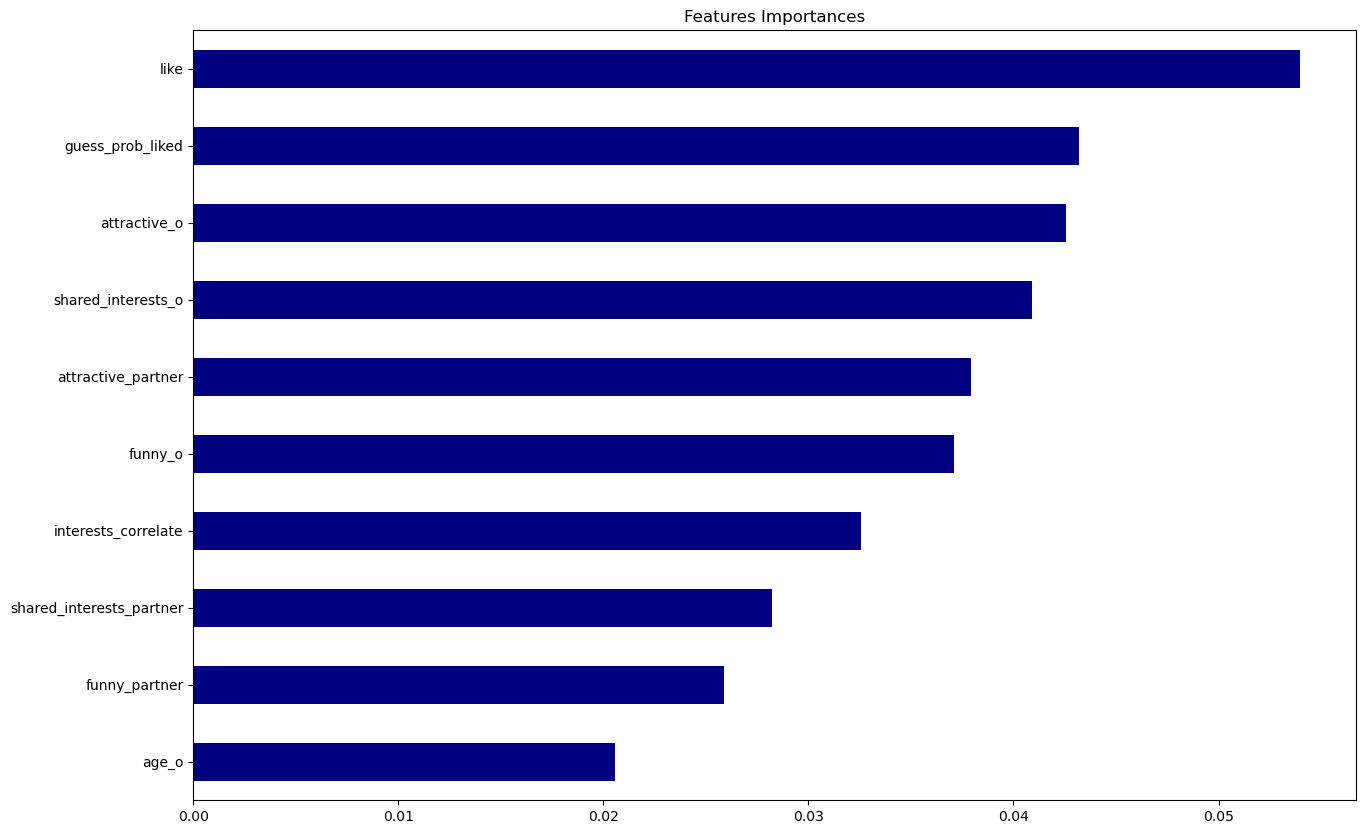

In [21]:
# Visualize the features by importance and save the graph as a JPG file
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances').tail(10)
importances_sorted.plot(kind='barh', color='navy', ylabel='', title= 'Features Importances', legend=False, figsize=(15,10))

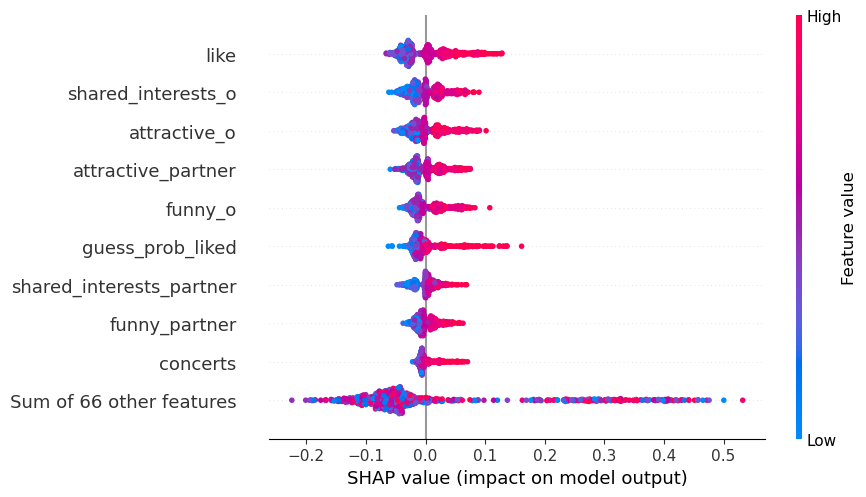

In [22]:
# Graph the SHAP values of the model with the explainer
explainer = shap.Explainer(rf_model, feature_names=X.columns)
shap_values = explainer(X_train_scaled)
shap.plots.beeswarm(shap_values[:,:,1])
plt.show()

# Deep Learning Model

In [44]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu', 'leaky_relu', 'gelu'])
    activation_last = hp.Choice('activation_last',['sigmoid', 'tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=500,
        step=5), activation=activation, input_dim=len(X_train.columns)))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 20)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=500,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation=activation_last))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [45]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=50,
    hyperband_iterations=2,
    directory=os.path.normpath('C:/'),
    project_name='speeddating_keras_tuner',
    overwrite=True)

In [46]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 180 Complete [00h 00m 13s]
val_accuracy: 0.8664122223854065

Best val_accuracy So Far: 0.8931297659873962
Total elapsed time: 00h 20m 05s


In [34]:
# Get top 10 model hyperparameters and print the values
from pprint import pprint
top_hps = tuner.get_best_hyperparameters(10)
for param in top_hps:
    pprint(param.values)
    print('-'*40)

{'activation': 'leaky_relu',
 'activation_last': 'tanh',
 'first_units': 371,
 'num_layers': 14,
 'tuner/bracket': 0,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units_0': 156,
 'units_1': 311,
 'units_10': 331,
 'units_11': 16,
 'units_12': 291,
 'units_13': 416,
 'units_14': 211,
 'units_15': 166,
 'units_16': 421,
 'units_17': 456,
 'units_18': 306,
 'units_19': 396,
 'units_2': 36,
 'units_3': 76,
 'units_4': 11,
 'units_5': 306,
 'units_6': 306,
 'units_7': 196,
 'units_8': 481,
 'units_9': 51}
----------------------------------------
{'activation': 'relu',
 'activation_last': 'sigmoid',
 'first_units': 421,
 'num_layers': 1,
 'tuner/bracket': 1,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/round': 1,
 'tuner/trial_id': '0051',
 'units_0': 376,
 'units_1': 471,
 'units_10': 396,
 'units_11': 381,
 'units_12': 266,
 'units_13': 346,
 'units_14': 316,
 'units_15': 176,
 'units_16': 426,
 'units_17': 146,
 'units_18': 76,
 'units_19': 136,
 'units_

In [35]:
# Evaluate the top 3 models against the test dataset
top_models = tuner.get_best_models(3)
for model in top_models:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
    print('-'*80)

9/9 - 0s - loss: 0.3724 - accuracy: 0.8855 - 310ms/epoch - 34ms/step
Loss: 0.3724122643470764, Accuracy: 0.885496199131012
--------------------------------------------------------------------------------
9/9 - 0s - loss: 0.4171 - accuracy: 0.8817 - 171ms/epoch - 19ms/step
Loss: 0.4170888364315033, Accuracy: 0.8816794157028198
--------------------------------------------------------------------------------
9/9 - 0s - loss: 0.4508 - accuracy: 0.8817 - 333ms/epoch - 37ms/step
Loss: 0.45078742504119873, Accuracy: 0.8816794157028198
--------------------------------------------------------------------------------


In [36]:
best_model = tuner.get_best_models()[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 371)               28196     
                                                                 
 dense_1 (Dense)             (None, 156)               58032     
                                                                 
 dense_2 (Dense)             (None, 311)               48827     
                                                                 
 dense_3 (Dense)             (None, 36)                11232     
                                                                 
 dense_4 (Dense)             (None, 76)                2812      
                                                                 
 dense_5 (Dense)             (None, 11)                847       
                                                                 
 dense_6 (Dense)             (None, 306)               3

In [41]:
#Predict
best_hps=tuner.get_best_hyperparameters()[0]

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train_scaled, y_train, epochs=50)

val_acc_per_epoch = history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
25/25 [==============================] - 2s 5ms/step - loss: 0.5408 - accuracy: 0.8232
Epoch 2/50
25/25 [==============================] - 0s 5ms/step - loss: 0.3798 - accuracy: 0.8422
Epoch 3/50
25/25 [==============================] - 0s 5ms/step - loss: 0.2998 - accuracy: 0.8664
Epoch 4/50
25/25 [==============================] - 0s 5ms/step - loss: 0.3219 - accuracy: 0.8817
Epoch 5/50
25/25 [==============================] - 0s 5ms/step - loss: 0.3102 - accuracy: 0.8880
Epoch 6/50
25/25 [==============================] - 0s 5ms/step - loss: 0.2790 - accuracy: 0.9071
Epoch 7/50
25/25 [==============================] - 0s 5ms/step - loss: 0.2935 - accuracy: 0.9275
Epoch 8/50
25/25 [==============================] - 0s 5ms/step - loss: 0.4019 - accuracy: 0.8957
Epoch 9/50
25/25 [==============================] - 0s 5ms/step - loss: 0.2671 - accuracy: 0.9198
Epoch 10/50
25/25 [==============================] - 0s 5ms/step - loss: 0.2208 - accuracy: 0.9109
Epoch 11/50
25/25 [

In [43]:
# Evaluate the model using the test data
model_loss, model_accuracy = hypermodel.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

9/9 - 0s - loss: 1.6677 - accuracy: 0.8511 - 213ms/epoch - 24ms/step
Loss: 1.667698860168457, Accuracy: 0.8511450290679932
